加载数据...


Building prefix dict from the default dictionary ...


数据集大小: 30000

类别分布:
label
体育    5000
家居    5000
房产    5000
教育    5000
科技    5000
财经    5000
Name: count, dtype: int64
开始文本预处理...


Dumping model to file cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.676 seconds.
Prefix dict has been built successfully.


训练集大小: 4000
测试集大小: 13000
验证集大小: 13000
开始特征提取...
特征维度: 5000
开始模型训练...

模型评估结果:

测试集评估结果：
              precision    recall  f1-score   support

          体育       0.99      0.99      0.99      2166
          家居       0.89      0.98      0.93      2167
          房产       0.99      0.99      0.99      2166
          教育       0.95      0.89      0.91      2167
          科技       0.92      0.93      0.92      2167
          财经       0.97      0.92      0.95      2167

    accuracy                           0.95     13000
   macro avg       0.95      0.95      0.95     13000
weighted avg       0.95      0.95      0.95     13000


验证集评估结果：
              precision    recall  f1-score   support

          体育       0.99      0.99      0.99      2167
          家居       0.88      0.98      0.93      2166
          房产       0.99      0.99      0.99      2167
          教育       0.95      0.88      0.91      2167
          科技       0.92      0.92      0.92      2167
          财经       0.96      0.93 

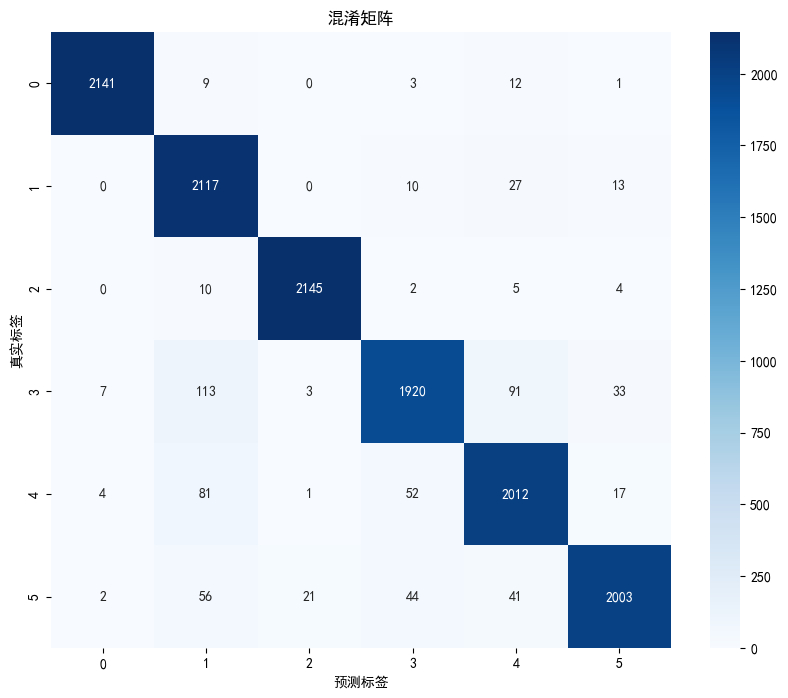

In [9]:
import numpy as np
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取停用词
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = [line.strip() for line in f.readlines()]
    return set(stopwords)

# 加载数据
def load_data(file_path):
    data = []
    labels = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                label, text = line.strip().split('\t')
                data.append(text)
                labels.append(label)
            except:
                continue
    
    return pd.DataFrame({'text': data, 'label': labels})

# 文本预处理函数
def preprocess_text(text, stopwords):
    # 分词
    words = jieba.cut(text)
    # 去停用词
    words = [word for word in words if word not in stopwords and word.strip()]
    return ' '.join(words)

# 数据预处理
def prepare_data(df, stopwords):
    print("开始文本预处理...")
    # 预处理文本
    df['processed_text'] = df['text'].apply(lambda x: preprocess_text(x, stopwords))
    
    # 划分数据集
    X = df['processed_text']
    y = df['label']
    
    # 训练集4000，测试集500，验证集500
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=4000, random_state=42, stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
    print(f"验证集大小: {len(X_val)}")
    
    return X_train, X_test, X_val, y_train, y_test, y_val

# 特征提取
def extract_features(X_train, X_test, X_val):
    print("开始特征提取...")
    tfidf = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    X_val_tfidf = tfidf.transform(X_val)
    
    print(f"特征维度: {X_train_tfidf.shape[1]}")
    return X_train_tfidf, X_test_tfidf, X_val_tfidf

# 模型训练
def train_model(X_train, y_train):
    print("开始模型训练...")
    gbdt = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    gbdt.fit(X_train, y_train)
    return gbdt

# 模型评估
def evaluate_model(model, X_test, y_test, X_val, y_val):
    print("\n模型评估结果:")
    
    # 测试集评估
    y_pred_test = model.predict(X_test)
    print("\n测试集评估结果：")
    print(classification_report(y_test, y_pred_test))
    
    # 验证集评估
    y_pred_val = model.predict(X_val)
    print("\n验证集评估结果：")
    print(classification_report(y_val, y_pred_val))
    
    # 混淆矩阵
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('混淆矩阵')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.show()

def main():
    # 1. 加载数据
    print("加载数据...")
    df = load_data('C:/Users/Lenovo/Desktop/chinese_text_classification/filtered_cnews.train.txt')
    print(f"数据集大小: {len(df)}")
    print("\n类别分布:")
    print(df['label'].value_counts())
    
    # 2. 加载停用词
    stopwords = load_stopwords('C:/Users/Lenovo/Desktop/chinese_text_classification/stopwords.txt')
    
    # 3. 准备数据
    X_train, X_test, X_val, y_train, y_test, y_val = prepare_data(df, stopwords)
    
    # 4. 特征提取
    X_train_tfidf, X_test_tfidf, X_val_tfidf = extract_features(X_train, X_test, X_val)
    
    # 5. 模型训练
    model = train_model(X_train_tfidf, y_train)
    
    # 6. 模型评估
    evaluate_model(model, X_test_tfidf, y_test, X_val_tfidf, y_val)

if __name__ == "__main__":
    main()